This notebook shows doing air pollution modeling by using features from the transportation network instead of only calculate road density at the location of the groud monitor. 

Firstly install packages, with Kaggel you dont have to set the conda Environment.  This Python 3 environment comes with many helpful analytics libraries installed.
It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import read_csv
import os
import matplotlib.pyplot as plt
 
import xgboost as xgb
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import tensorflow as tf

import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential  
from sklearn.utils import shuffle
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import gc



"""
Created on Tue Mar 17 16:19:38 2020

@author: menglu
"""




Using TensorFlow backend.


'\nCreated on Tue Mar 17 16:19:38 2020\n\n@author: menglu\n'

In [2]:
batch_size = 16
epochs = 50
n =3 
version = 2
data_augmentation = False
subtract_pixel_mean = False
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

Load transportation network, they consists of 5 road types rasterized from OpenStreetMaps. Road1: highway, Road2: primary roads, road3: secondaryroads, road4: tertiary roads, road5: local roads

In [3]:
road1 = np.load('../input/road645211/road64_5221/road_641.npy')
road2 = np.load('../input/road645211/road64_5221/road_642.npy')
road3 = np.load('../input/road645211/road64_5221/road_643.npy')
road4 = np.load('../input/road645211/road64_5221/road_644.npy')
road5 = np.load('../input/road645211/road64_5221/road_645.npy')
#road3 = np.load('../input/ap-road/road3.npy')
#road2 = np.load('../input/ap-road/road2.npy')
#road5 = np.load('../input/ap-road/road5.npy')

road234=np.array((road1, road2,road3, road4, road5))
print(road234.shape)
road234= np.where(road234 > 1, 1, 0) # convert to binary
 

(5, 5521, 64, 64)


Reshape the 4-d array to observations, width, hight, channel (different road types)

In [4]:
road234r = np.moveaxis(road234, 1, 0)
road234r = np.moveaxis(road234r, 1, -1) # channel last: ! be super careful about what array reshape mean, it is not the same as movng axis!!
# road234r, Y = shuffle(road234r, Y) Why shuffle results in nan?
road234r.shape

(5521, 64, 64, 5)

* look at different roads of different road types 

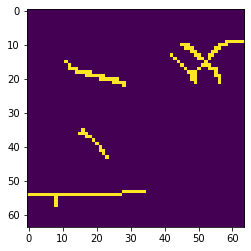

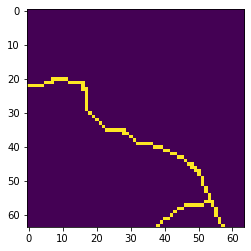

1

In [5]:
plt.imshow(road234r[1,:,:,3])
plt.show() 
plt.imshow(road234r[10,:,:,3])
plt.show() 
np.max(road234r[10,:,:,3])

Load air pollution station measurements and split data into train+validation and test

In [6]:
ap = read_csv('../input/global5221/global_annual.csv')
 
ap_pred = ap.filter (regex="pop|nig|trop|ele|wind|temp|ind|GH")


Xtrainv, Xtest, Ytrainv, Ytest = train_test_split(road234r, ap['value_mean'], test_size=0.2, random_state=42)
Xtrain_rf, Xtest_rf, Ytrain2, Ytest2 = train_test_split(ap_pred, ap['value_mean'], test_size=0.2, random_state=42)
Xtrain_rf= StandardScaler().fit (Xtrain_rf).transform(Xtrain_rf) 
Xtest_rf= StandardScaler().fit (Xtest_rf).transform(Xtest_rf) 
 
assert (sum(Ytrain2-Ytrainv)==0)
print(Xtrainv.shape, Xtest.shape, Xtrainv.shape, Ytest.shape)
print(Xtrain_rf)
input_shape = Xtrainv.shape[1:] 
#ap_pred.columns 


(4416, 64, 64, 5) (1105, 64, 64, 5) (4416, 64, 64, 5) (1105,)
[[-0.61305576 -0.64069792 -0.1851791  ... -0.15258658 -0.80464998
  -0.15335502]
 [-0.00565459  0.0431002  -0.48287297 ... -1.72022074 -1.62079424
   0.66529797]
 [ 0.34845561  0.442272   -0.52030799 ... -0.75636561 -0.97446762
   1.44086355]
 ...
 [ 0.52544684  0.56762098  0.2307444  ...  0.33582851 -0.44517907
   1.03288359]
 [-0.58234174 -0.6241919  -0.64770125 ... -0.03590813  0.77034811
   0.13613562]
 [-1.00914715 -0.99190761 -0.92931821 ... -0.77291065 -0.81676002
   0.52930422]]


In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 1e-3
    elif epoch > 160:
        lr *= 5e-2
    elif epoch > 120:
        lr *= 1e-1
    elif epoch > 80:
        lr *= 5e-1
    print('Learning rate: ', lr)
    return lr


Creates a simple fully connected neural network (for background variables)

In [8]:
def point_nn(dim, regularizer=None):
    
    model = Sequential()
    model.add(Dense(16, input_dim=dim,  kernel_initializer='random_normal', kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(keras.layers.Dropout(0.1))
    #model.add(Activation('relu'))
    #model.add(Dense(16,  kernel_initializer='random_normal', kernel_regularizer=regularizer))
    
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Dense(8,  kernel_initializer='random_normal', kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1, activation="linear", kernel_initializer='random_normal',kernel_regularizer=regularizer))
    return model

Decenting gradient much more stable after scaling and a faster learning rate could be used. we reach an mae of 11, which is higher than using xgb, which reach to 8

In [9]:
pnn = point_nn(Xtrain_rf.shape[1]) 
print(Xtrain_rf.shape[1])
pnn.compile(loss='mae',
              optimizer=Adam(learning_rate=0.005),
              metrics=['mse', 'mae']) 
pnn.fit(Xtrain_rf, Ytrainv,
              batch_size=batch_size,
              epochs=50,
              validation_data=(Xtest_rf, Ytest))
 

44
Epoch 1/50
276/276 [==============================] - 1s 5ms/step - loss: 17.4017 - mse: 480.5512 - mae: 17.4017 - val_loss: 11.7129 - val_mse: 229.9296 - val_mae: 11.7129
Epoch 2/50
276/276 [==============================] - 1s 3ms/step - loss: 10.9069 - mse: 196.6767 - mae: 10.9069 - val_loss: 12.0031 - val_mse: 247.0135 - val_mae: 12.0031
Epoch 3/50
276/276 [==============================] - 1s 3ms/step - loss: 10.9052 - mse: 195.0612 - mae: 10.9052 - val_loss: 11.5833 - val_mse: 208.4087 - val_mae: 11.5833
Epoch 4/50
276/276 [==============================] - 1s 3ms/step - loss: 10.9039 - mse: 195.7753 - mae: 10.9039 - val_loss: 11.6539 - val_mse: 208.4501 - val_mae: 11.6539
Epoch 5/50
276/276 [==============================] - 1s 3ms/step - loss: 10.9091 - mse: 194.9291 - mae: 10.9091 - val_loss: 11.5412 - val_mse: 209.3152 - val_mae: 11.5412
Epoch 6/50
276/276 [==============================] - 1s 3ms/step - loss: 10.9137 - mse: 195.8355 - mae: 10.9137 - val_loss: 11.7477 - va

276/276 [==============================] - 1s 3ms/step - loss: 10.9081 - mse: 195.5239 - mae: 10.9081 - val_loss: 13.2142 - val_mse: 245.2177 - val_mae: 13.2142
Epoch 49/50
276/276 [==============================] - 1s 3ms/step - loss: 10.9047 - mse: 195.5042 - mae: 10.9047 - val_loss: 11.7387 - val_mse: 231.6023 - val_mae: 11.7387
Epoch 50/50
276/276 [==============================] - 1s 4ms/step - loss: 10.9025 - mse: 194.6138 - mae: 10.9025 - val_loss: 11.5246 - val_mse: 213.5524 - val_mae: 11.5246


RestNet

with only road resnet cnn, we reach an mae of about 10

2D Convolution-Batch Normalization-Activation stack builder

-- Arguments 
*        inputs (tensor): input tensor from input image or previous layer
*        num_filters (int): Conv2D number of filters
*        kernel_size (int): Conv2D square kernel dimensions
*        strides (int): Conv2D square stride dimensions
*        activation (string): activation name
*        batch_normalization (bool): whether to include batch normalization
*        conv_first (bool): conv-bn-activation (True) or
*            bn-activation-conv (False)

-- Returns
*        x (tensor): tensor as input to the next layer
 

In [10]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='random_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [11]:
def resnet_v1(input_shape, depth, num_classes=1):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='relu',
                    kernel_initializer='random_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape,  depth, num_classes=1):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense (num_classes,
                    activation='linear',
                    kernel_initializer='random_normal')(y)
        # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)

    return model

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   736         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 64, 64, 16)   0           batch_normalization_2[0][0]      
______________________________________________________________________

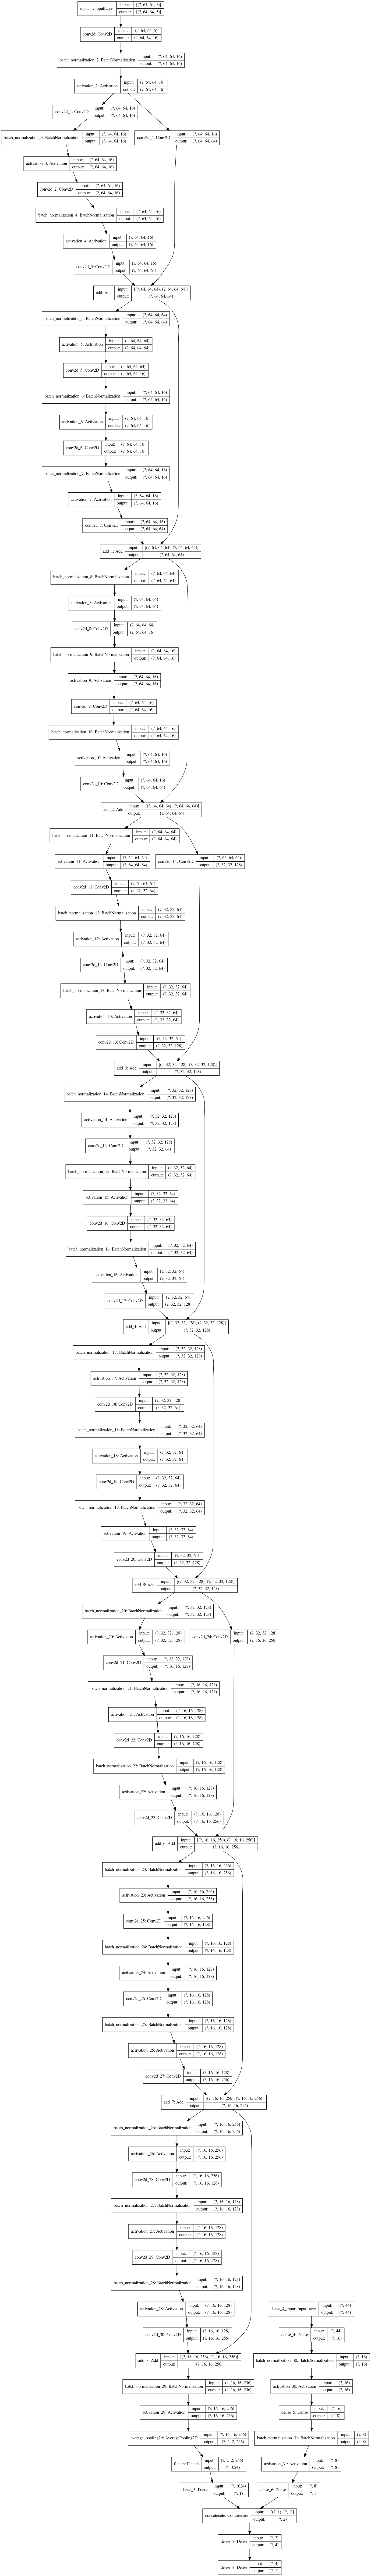

In [13]:
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU

#with tpu_strategy.scope():
     
    #if version == 2:
res_model = resnet_v2(input_shape=input_shape,  depth=depth, num_classes=1)
    #else:
      #  res_model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=1)

pnn = point_nn(Xtrain_rf.shape[1]) 

concatted = concatenate([pnn.output, res_model.output])
dense1 = Dense(4,
                    activation='relu',kernel_initializer='random_normal')(concatted)
outputs = Dense(1,
                    activation='linear',kernel_initializer='random_normal')(dense1)

model_mix = Model(inputs=[pnn.input,res_model.input], outputs=outputs)

model_mix.compile(loss='mae',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['mse', 'mae']) 
model_mix.summary()
tf.keras.utils.plot_model(model_mix, to_file="/kaggle/working/model_mixed.png", show_shapes=True)

#BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

In [14]:

# Prepare model model saving directory.
save_dir = os.path.join('saved_models')
model_name = 'mix_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

 

In [15]:

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model_mix.fit([Xtrain_rf, Xtrainv], Ytrainv,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=([Xtest_rf,Xtest], Ytest),
                    callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit([Xtrain_rf,Xtrainv])

    # Fit the model on the batches generated by datagen.flow().
    model_mix.fit_generator(datagen.flow( [Xtrain_rf, Xtrainv], Ytrainv, batch_size=batch_size),
                        validation_data=([Xtest_rf,Xtest], Ytest),
                        epochs=epochs, verbose=1, workers=4,
                     callbacks=callbacks)

# Score trained model.
scores = model_mix.evaluate([Xtest_rf, Xtest], Ytest, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Not using data augmentation.
Learning rate:  0.001
Epoch 1/50
276/276 [==============================] - 9s 33ms/step - loss: 14.7394 - mse: 377.0703 - mae: 14.6560 - val_loss: 21.6147 - val_mse: 666.7951 - val_mae: 21.5282 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
276/276 [==============================] - 8s 29ms/step - loss: 8.8812 - mse: 137.0180 - mae: 8.7950 - val_loss: 9.5703 - val_mse: 167.3041 - val_mae: 9.4855 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
276/276 [==============================] - 8s 29ms/step - loss: 8.7224 - mse: 134.7180 - mae: 8.6387 - val_loss: 9.5206 - val_mse: 161.5018 - val_mae: 9.4384 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
276/276 [==============================] - 8s 29ms/step - loss: 8.6634 - mse: 131.6693 - mae: 8.5835 - val_loss: 14.2475 - val_mse: 324.2070 - val_mae: 14.1695 - lr: 0.0010
Learning rate:  0.001
Epoch 5/50
276/276 [==============================] - 8s 29ms/step - loss: 8.7823 - mse: 135.2933 - mae: 8.7027 - val_loss: 9.2

Learning rate:  0.001
Epoch 41/50
276/276 [==============================] - 8s 28ms/step - loss: 5.9917 - mse: 68.7358 - mae: 5.7631 - val_loss: 10.0103 - val_mse: 162.8226 - val_mae: 9.7798 - lr: 0.0010
Learning rate:  0.001
Epoch 42/50
276/276 [==============================] - 8s 29ms/step - loss: 5.8551 - mse: 66.0468 - mae: 5.6221 - val_loss: 9.9606 - val_mse: 170.3060 - val_mae: 9.7260 - lr: 3.1623e-04
Learning rate:  0.001
Epoch 43/50
276/276 [==============================] - 8s 30ms/step - loss: 5.8027 - mse: 64.1730 - mae: 5.5660 - val_loss: 9.9800 - val_mse: 164.0530 - val_mae: 9.7416 - lr: 0.0010
Learning rate:  0.001
Epoch 44/50
276/276 [==============================] - 8s 30ms/step - loss: 5.6523 - mse: 60.6869 - mae: 5.4130 - val_loss: 10.3737 - val_mse: 185.5823 - val_mae: 10.1331 - lr: 0.0010
Learning rate:  0.001
Epoch 45/50
276/276 [==============================] - 8s 29ms/step - loss: 5.6106 - mse: 59.3818 - mae: 5.3679 - val_loss: 11.9760 - val_mse: 252.7156 - v

compile only set up hyperparameters and error metrics, fit will do the training

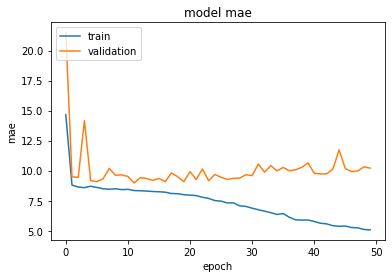

In [16]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# save before show(), otherwise wont work
plt.savefig("/kaggle/working/apcnn.png")
plt.show()

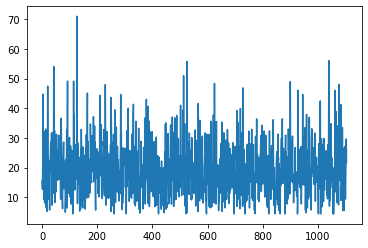

In [18]:
apmap = model_mix.predict([Xtest_rf,Xtest])
plt.plot(apmap)

In [22]:
utroad2 = np.load('../input/utrechtroads/utroad2.npy')
utroad3 = np.load('../input/utrechtroads/utroad3.npy')
utroad4 = np.load('../input/utrechtroads/utroad4.npy')
utroad5 = np.load('../input/utrechtroads/utroad5.npy')
utroad234=np.array(( utroad2,utroad3, utroad4, utroad5))
utroad234.shape

utroad234r = np.moveaxis(utroad234, 2, 0)
utroad234r = np.moveaxis(utroad234r, 1, -1) # channel last
 

utroad234r= np.where(utroad234r > 1, 1, 0)
 
  


In [23]:
np.median(utroad234r)

0.0

64

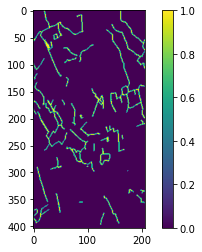

In [33]:
plt.imshow(utroad234r[:,:,3])
plt.colorbar()
input_shape[1]


In [25]:
del road234
del road234r
del road1
del road2 
del road3
del road4 
del road5
del ap
del utroad2
del utroad3
del utroad4
del utroad5
del utroad234
gc.collect()

12317

In [28]:
import psutil
psutil.virtual_memory()
16824520704
3182387200
13334953984/1024/1024/1024

12.419143676757812

In [ ]:
#from keras.models import load_model
 
# load model
#model = load_model('/kaggle/working/model1.h5')

In [31]:
def slice (arr, size):
    result = []
    for i in range(0, (403-size)):
        for j in range(0, (207-size)):
        
            s = arr[i:(i+size),j:(j+size),:]
            result.append(s)
 
    result = np.array(result)
    return result


In [34]:
result = slice (utroad234r, input_shape[1])
Utrechtmap = model_mix.predict(result)
Utrechtmap.shape

NameError: name 'model' is not defined

In [ ]:
apmap = Utrechtmap.reshape(371,175)


In [ ]:
imgplot = plt.imshow(apmap)
plt.colorbar()

plt.savefig('/kaggle/working/utrechtmap.png')

In [ ]:
np.savetxt('/kaggle/working/apmap.csv', apmap, delimiter=',')